# Introduction

This is an extensive Exploratory Data Aanalysis for the Student Major Prediction within the Python Environment. 
We will visualise all the different data features, their relation to the target variable, explore multi-parameter interactions, and perform feature engineering.

The aim of this challenge is to use historical data of student course records to predict potential majors for new students who have yet to declare their major. 

The data contains one training and test file each: ./training.psv & ./eval.psv.
Each row corresponds to a specific student course record and the columns describe their features (grade, level, course name). The target variable is the major of the student.

# Loading packages & data

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [146]:
train=pd.read_csv('training.psv',delimiter='|')
test = pd.read_csv('eval.psv',delimiter = '|')

Check basic information of  data

In [147]:
##display the first five rows of the train dataset.
train.head(5)

,student_id,level,course,grade,major
0,ppVGBRKhtqqyxnVO,Freshman,SPAN:100,A,Business
1,PiPkSgMGbFIu5RwR,Freshman,CSI:160,S,International Relations
2,PiPkSgMGbFIu5RwR,Sophomore,EES:107,C,International Relations
3,PiPkSgMGbFIu5RwR,Senior,SPAN:201,B,International Relations
4,PiPkSgMGbFIu5RwR,Junior,ENTR:200,B+,International Relations


In [148]:
##display the first five rows of the test dataset.
test.head(5)

,student_id,level,course,grade,major1,major2,major3
0,6Q79FVMSbTPMBhha,Senior,ECE:489,A,NaN,NaN,NaN
1,6Q79FVMSbTPMBhha,Sophomore,MATH:246,B,NaN,NaN,NaN
2,6Q79FVMSbTPMBhha,Sophomore,ECE:344,C+,NaN,NaN,NaN
3,6Q79FVMSbTPMBhha,Junior,ARTS:280,B,NaN,NaN,NaN
4,6Q79FVMSbTPMBhha,Freshman,CSI:160,AUS,NaN,NaN,NaN


In [149]:
# Check missing value in train data
print('Missing value in train is  {} '.format(train.isnull().sum(axis=0).values.sum()))
# ['major1','major2','major3'] is droped in test set
print('Missing value in train is  {}'.format(test.drop(['major1','major2','major3'],axis=1).isnull().sum(axis=0).values.sum()))

Missing value in train is  0 
Missing value in train is  0


In [150]:
# check the total number of distinct major
print("The total number of distinct major is :", train.major.nunique())
# check the total number of course
print("The total number of distinct course is :", train.course.nunique())
# check the total number of level
print("The total number of distinct level is :", train.level.nunique())
# check the total number of grade
print("The total number of distinct grade is :", train.grade.nunique())

The total number of distinct major is : 81
The total number of distinct course is : 2721
The total number of distinct level is : 4
The total number of distinct grade is : 21


In [151]:
# check the distinct major of training dataset
print("The distinct grade in training dataset is :", train.grade.unique())
# check the distinct major of test dataset
print("The distinct grade in test dataset is :", test.grade.unique())

The distinct grade in training dataset is : ['A' 'S' 'C' 'B' 'B+' 'D+' 'A-' 'C+' 'B-' 'D' 'A+' 'C-' 'R' 'AUS' 'D-' 'I'
 'P' 'U' 'WX' 'AUU' 'N']
The distinct grade in test dataset is : ['A' 'B' 'C+' 'AUS' 'A-' 'B+' 'S' 'B-' 'C-' 'D' 'C' 'A+' 'D-' 'D+' 'P' 'R'
 'I' 'N' 'WX' 'AUU' 'U']


We found that the number of distinct grade in training data and evaluation data is 21. 
Though 'I', 'WX', 'R' are not listed in the grades table, they existed in the training and testing dataset. We will use them as aditional features.

In [152]:
# check the distinct number of student_id in training dataset
print("The distinct number of student_id in training dataset is :", train.student_id.nunique())
# check the distinct number of student_id in test dataset
print("The distinct number of student_id in test dataset is  :", test.student_id.nunique())

The distinct number of student_id in training dataset is : 10000
The distinct number of student_id in test dataset is  : 2000


In [153]:
# check the shape
print("The train data shape is : {} ".format(train.shape))
print("The test data shape is : {} ".format(test.shape))

The train data shape is : (97276, 5) 
The test data shape is : (19440, 7) 


# Data visulization 

Before feature engineering, we only have three features, which are level, grade, course name. The distinct number of  course name, level, grade are 2721, 4, 21. All of them are categorical features. The large number of distinct course name makes it difficult to make the plot. 

So here we simply use a count plot to see how grade distributed in different level. We will make more plots after implement feature engineering.

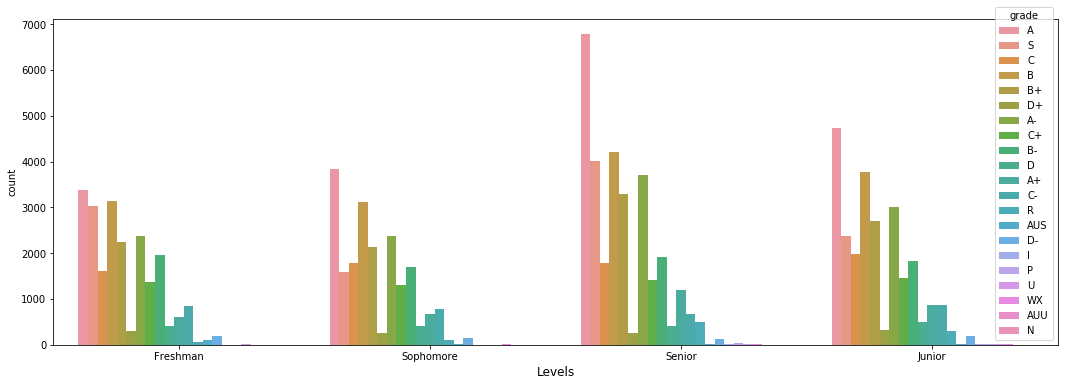

In [154]:
fig, ax = plt.subplots( figsize=(18, 6))
ax = sns.countplot(x="level", hue="grade", data=train)
ax.set_xlabel('Levels', fontsize=12)
plt.show()

From this count plot, we can tell: 
1. Senior level contributes the largest part of observations.
2. The grade distribution of different levels have similar shape.

# Feature Engneering

In [155]:
# combine train and test as data.
ntrain = train.shape[0]
ntest = test.shape[0]
# Extract the target variables
major = train['major']
obs_tr=train.shape[0]
obs_ev=test.shape[0]
cols=['student_id', 'level', 'course', 'grade']
data=pd.concat([train[cols],test[cols]],axis=0)
print("data size is : {}".format(data.shape))

data size is : (116716, 4)


 ## Feature Engneering on grade column

### Transforing Grades A-F to values

In [156]:
# First transforing grades A-F to values, lower grade is corresponding to lager value
data['letter_grade']=data.grade.map({'A+':1,'A':2,'A-':3,'B+':4,'B':5,'B-':6,
                                       'C+':7,'C':8,'C-':9,'D+':10,'D':11,'D-':12,'F':13})
data['letter_grade']=data['letter_grade'].fillna(0)
data.letter_grade.unique()

array([ 2.,  0.,  8.,  5.,  4., 10.,  3.,  7.,  6., 11.,  1.,  9., 12.])

### Feature on other grades (except A-F )

In [157]:
# functions that create new features from grade
def satis(s):
    if s=='S':return 1
    elif s=='U':return 0
    else: return -1
def aud(s):
    if s=='AUS': return 1
    elif s=='AUU': return 0
    else:return -1
def ps(s):
    if s=='P': return 1
    elif s=='N': return 0
    else: return -1
def adds(s):
    if s=='I': return 1
    elif s=='WX': return 2
    elif s=='R':return 3
    else: return 0

In [158]:
# create new feature S from grade, it tells whether the student has get Satisfactory grade or not
data['S']=data.grade.apply(satis)
# create new feature P from grade, it tells whether the student has pass the course or not
data['P']=data.grade.apply(ps)
# create new feature AU from grade, it tells whether the student has Audit the course successfully or not
data['AU']=data.grade.apply(aud)
## create new feature unknown_grade from grade, it tells whether the student has get unknown grade for the course or not
data['unknown_grade']=data.grade.apply(adds)

## Feature Engneering on level column

In [159]:
# Use number to represent students' level, larger number means higher level
data['level']=data['level'].map({'Freshman':1,'Sophomore':2,'Junior':3,'Senior':4})

## Feature Engneering on course column

Course are high cardinality features with no order, one_hot & lable encoding can't be applied here. A possible solution is target encoding.(https://medium.com/datadriveninvestor/improve-your-classification-models-using-mean-target-encoding-a3d573df31e8). However in this case, target has no order. So we extract the prefix which is closely related to major and aggregate it by its model grouped by student_id.

In [160]:
# define function to extract the prefix of the course name
def sep_course(s):
    A,B=s.split(':')
    return A
data['course_prefix']=data.course.apply(sep_course)
print('The unique number of the course prefix is : ', data.course_prefix.nunique())

The unique number of the course prefix is :  182


## Label encoding course prefix

In [161]:
le = preprocessing.LabelEncoder()
le.fit(data.course_prefix)
data['course_prefix']=le.transform(data.course_prefix)
data.head()

,student_id,level,course,grade,letter_grade,S,P,AU,unknown_grade,course_prefix
0,ppVGBRKhtqqyxnVO,1,SPAN:100,A,2.0,-1,-1,-1,0,162
1,PiPkSgMGbFIu5RwR,1,CSI:160,S,0.0,1,-1,-1,0,49
2,PiPkSgMGbFIu5RwR,2,EES:107,C,8.0,-1,-1,-1,0,60
3,PiPkSgMGbFIu5RwR,4,SPAN:201,B,5.0,-1,-1,-1,0,162
4,PiPkSgMGbFIu5RwR,3,ENTR:200,B+,4.0,-1,-1,-1,0,65


In [162]:
# Seperate the training and testing dataset, we will implement aggregation on 
d_train=data.iloc[0:obs_tr]
d_eval=data.iloc[-obs_ev:]
d_train['major']=train.major

## Label encoding major 

In [163]:
le1 = preprocessing.LabelEncoder()
le1.fit(train.major)
d_train['major']=le1.transform(d_train.major)
d_train.head()

,student_id,level,course,grade,letter_grade,S,P,AU,unknown_grade,course_prefix,major
0,ppVGBRKhtqqyxnVO,1,SPAN:100,A,2.0,-1,-1,-1,0,162,11
1,PiPkSgMGbFIu5RwR,1,CSI:160,S,0.0,1,-1,-1,0,49,45
2,PiPkSgMGbFIu5RwR,2,EES:107,C,8.0,-1,-1,-1,0,60,45
3,PiPkSgMGbFIu5RwR,4,SPAN:201,B,5.0,-1,-1,-1,0,162,45
4,PiPkSgMGbFIu5RwR,3,ENTR:200,B+,4.0,-1,-1,-1,0,65,45


# Agregation ( by student_id)
There are some student_ids show mutiple times in the training and test dataset, which indicates some students take different courses in different levels. To have a comprehensive student course records, we will implement feature aggregation (by student id).

1. Level: we will pick the highest level
2. Grade (S,P,AU,unknow_grade): we will pick the mean,variance, min, max, mode of the grade
3. Major: a specific student id only has one major
4. Course (prefix):we will pick the mode of the course prefix

In [164]:
df_train=d_train.groupby('student_id').agg({'level':'max',
                                          'major':lambda x: x.mode()[0],
                                          'letter_grade':['min','max','var','mean',lambda x: x.mode()[0]],
                                          'S':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'P':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'AU':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'unknown_grade':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'course_prefix':lambda x: x.mode()[0]
})
df_test=d_eval.groupby('student_id').agg({'level':'max',
                                          'letter_grade':['min','max','var','mean',lambda x: x.mode()[0]],
                                          'S':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'P':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'AU':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'unknown_grade':['sum','count',lambda x: x.mode()[0],'mean'],
                                          'course_prefix':lambda x: x.mode()[0]})
#rename columns
new_name=['student_id']+[df_train.columns.droplevel(1).tolist()[i]+'_'+df_train.columns.droplevel(0).tolist()[i] 
          for i in range(df_train.shape[1])]
new_name2=['student_id']+[df_test.columns.droplevel(1).tolist()[i]+'_'+df_test.columns.droplevel(0).tolist()[i] 
          for i in range(df_test.shape[1])]
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train.columns=new_name
df_test.columns=new_name2
df_train.head()

,student_id,level_max,major_<lambda>,letter_grade_min,letter_grade_max,letter_grade_var,letter_grade_mean,letter_grade_<lambda>,S_sum,S_count,...,P_mean,AU_sum,AU_count,AU_<lambda>,AU_mean,unknown_grade_sum,unknown_grade_count,unknown_grade_<lambda>,unknown_grade_mean,course_prefix_<lambda>
0,01DiJuoJAB395ucJ,4,13,5.0,5.0,NaN,5.000000,5.0,-1,1,...,-1.0,-1,1,-1,-1.0,0,1,0,0.000000,121
1,01MhxeQl5FhRsf3f,1,11,8.0,8.0,NaN,8.000000,8.0,-1,1,...,-1.0,-1,1,-1,-1.0,0,1,0,0.000000,162
2,01W7KB8TDNWNx4YW,4,68,0.0,9.0,8.225275,4.071429,5.0,-12,14,...,-1.0,-14,14,-1,-1.0,3,14,0,0.214286,142
3,042Rmpv5B2kXdfBR,3,20,6.0,6.0,NaN,6.000000,6.0,-1,1,...,-1.0,-1,1,-1,-1.0,0,1,0,0.000000,138
4,04DuzbneGqk0o0jY,2,29,4.0,4.0,NaN,4.000000,4.0,-1,1,...,-1.0,-1,1,-1,-1.0,0,1,0,0.000000,167


In [165]:
# remove single value columns
#AU_<lambda> has only 1 unique value, drop it
df_train.drop('AU_<lambda>',axis=1,inplace=True)
df_test.drop('AU_<lambda>',axis=1,inplace=True)

In [166]:
df_train.fillna(0,inplace=True)
df_test.fillna(0,inplace=True)

# Exploratory data analysis on aggregated data

We start our exploration with overview distribution plots for the various features.

In [167]:
count = pd.DataFrame(df_train['major_<lambda>'].value_counts()).reset_index()
print("The top five majors with the largest distinct number of students in descending order is :", 
      le1.inverse_transform(count.head(5)['index'].values.tolist()))

The top five majors with the largest distinct number of students in descending order is : ['Business' 'Communication Studies' 'Psychology' 'Human Physiology'
 'English']


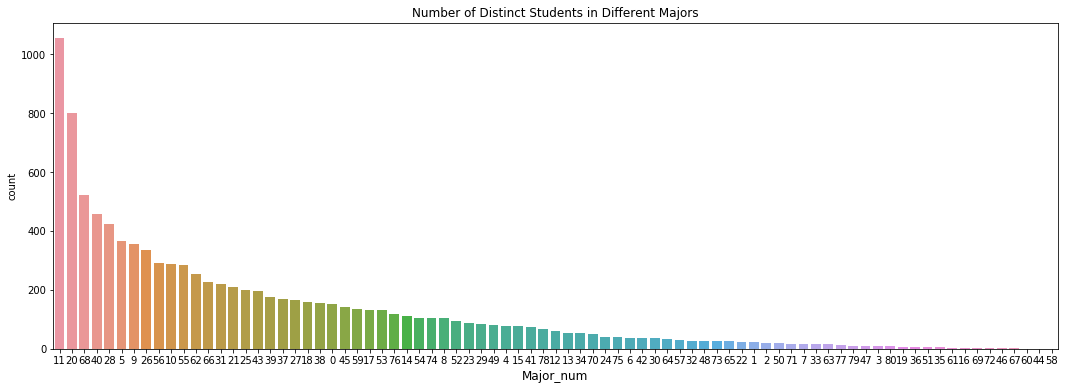

In [168]:
fig, ax = plt.subplots( figsize=(18, 6))
ax = sns.countplot(x="major_<lambda>", data=df_train, order = df_train['major_<lambda>'].value_counts().index)
ax.set_xlabel('Major_num', fontsize=12)
ax.set_title('Number of Distinct Students in Different Majors')
plt.show()

In [169]:
# Then check the level proportion in different majors, here we only use the top ten majors that have the largest 
# distinct number of students
top_10_majors = count.head(10)['index'].values.tolist()
df_top10 = df_train.loc[df_train['major_<lambda>'].isin(top_10_majors)]
df_top10['level']= df_top10['level_max'].map({1:'Freshman',2:'Sophomore',3:'Junior',4:'Senior'})
df_top10['major']=le1.inverse_transform(df_top10['major_<lambda>'])

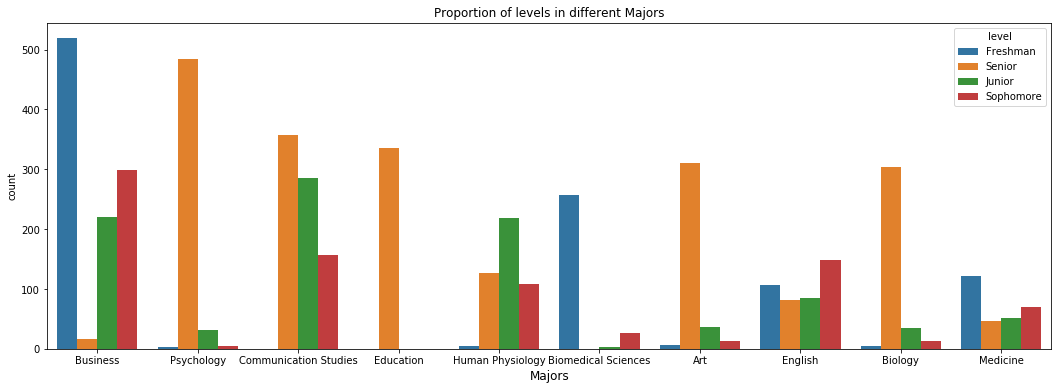

In [170]:
fig, ax = plt.subplots( figsize=(18, 6))
ax = sns.countplot(x="major", hue="level", data=df_top10)
ax.set_xlabel('Majors', fontsize=12)
ax.set_title('Proportion of levels in different Majors')
plt.show()

In [171]:
# Then check the level proportion in different majors, here we only use the top ten majors that have the largest 
# distinct number of students
top_5_majors = count.head(5)['index'].values.tolist()
df_top5 = df_train.loc[df_train['major_<lambda>'].isin(top_5_majors)]
df_top5['major']=le1.inverse_transform(df_top5['major_<lambda>'])
df_top5['course_prefix']=le.inverse_transform(df_top5['course_prefix_<lambda>'])

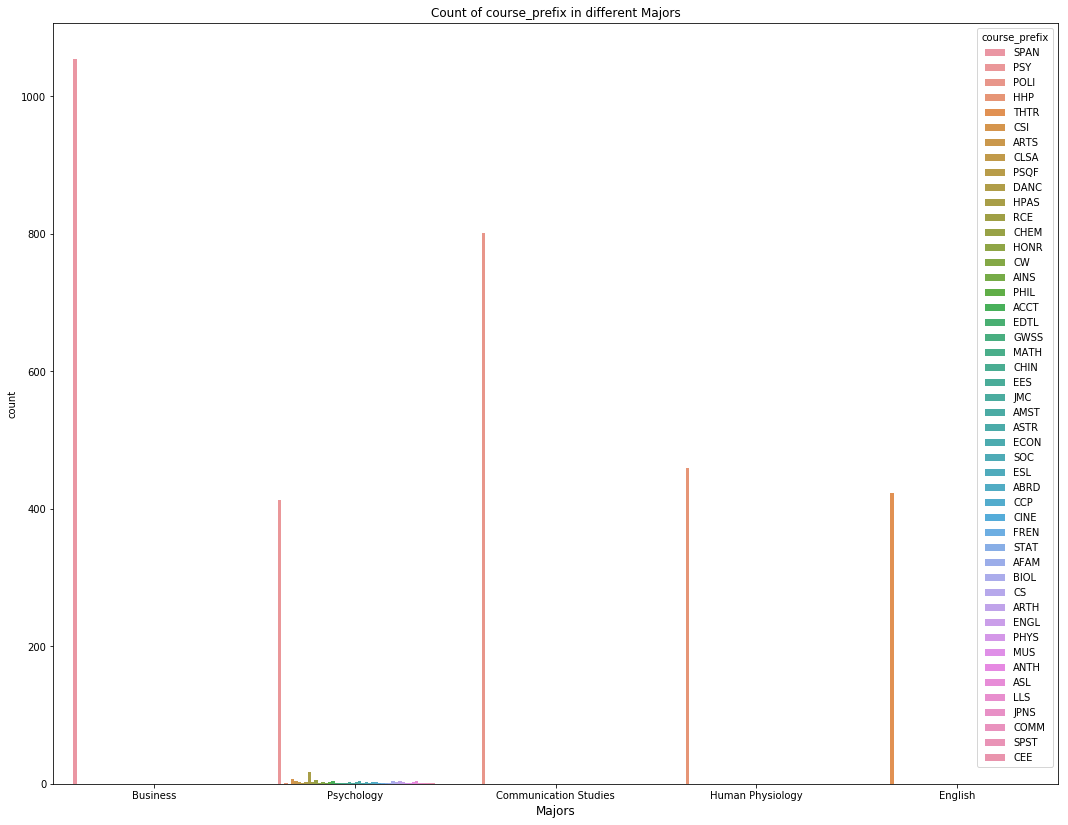

In [172]:
fig, ax = plt.subplots( figsize=(18, 14))
ax = sns.countplot(x="major", hue="course_prefix", data=df_top5)
ax.set_xlabel('Majors', fontsize=12)
ax.set_title('Count of course_prefix in different Majors')
plt.show()

From the countplot of course_name prefix of different major, we can tell: 
1. Students major in Business took a lot of courses with prefix 'SPAN'.
2. Students major in Psychology took a lot of courses with prefix 'PSY'.
3. Students major in Communication Studies took a lot of courses with prefix 'POLI'.

The prefix of the course name seems closely related to the major of the student.

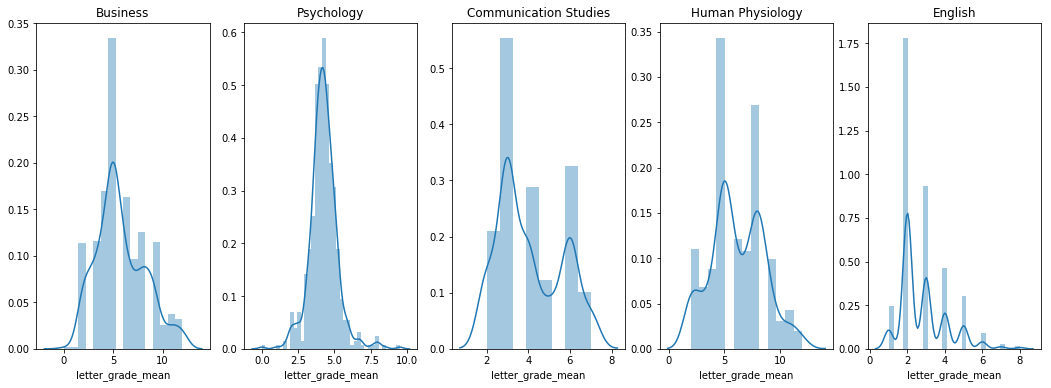

In [173]:
major_list = df_top5['major'].unique().tolist()
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 6))
for i in range(len(major_list)):
    data = df_top5.loc[df_top5['major']== major_list[i]]['letter_grade_mean']
    sns.distplot(data, ax=axes[i])
    axes[i].title.set_text(major_list[i])
plt.show()

For different major, the distribution of grade_mean is different.

The plots above confirmed the new features we creatd by feature aggregation are useful for major prediction.

# Build Tree model

Then we build a gradient-boosting classfification tree model to predict students major. 
There are three reasons why we choose the GBM model:
1. No assumption on structure of  data, 
2. Nonparametric, which is the case of the most real data.
3. Compared with traditional ML/statistical method, more accuracy on prediction.

In [174]:
features=[i for i in df_train.columns if i not in ['major_<lambda>','student_id','level'] ]
random_state=2019
lgb_params = {
    # Use softmax as loss function
    "objective" : "softmax",
    'num_class':81,
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.05,
    "bagging_freq": 5,
    "bagging_fraction" : 0.8,
    "feature_fraction" : 0.7,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

# Define the metric to evaluate our outcome.
For this case we define the metric to be an extended mutiple classfification accucary.

$MultipleACC=(N^{-1})\sum_{i=1}^{N}(I_i)$

Where $I_i$ is the Indicator function of :for i_th observation, true major is in the predicted top 3 majors.

Example: Suppose we have 100 students course taking records.
We use our model to predict three possible majors for each student. 
If the true major is in the three possible majors we predicted, then we prediction is correct.
If 90 students' major prediction is correct, then our model accuracy is 0.9.

In [175]:
def accuracy_multiple(preds, true):
    preds=preds.reshape((-1,81))
    preds =np.argpartition(preds,-3,axis=1)[:,-3:]
    preds=pd.DataFrame(preds)
    true=pd.DataFrame(true.values)
    acc=np.mean((true[0]==preds[0])+(true[0]==preds[1])+(true[0]==preds[2]))
    return 'multiclass Accuracy', acc

# Result (0.935 Accuracy)

In [176]:
from sklearn.model_selection import train_test_split
#help(train_test_split)
target=df_train['major_<lambda>']
X_train, X_valid, y_train, y_valid = train_test_split(df_train[features], 
                                                    target, test_size=0.15,
                                                    random_state=42)
trn_data = lgb.Dataset(X_train, y_train)
val_data = lgb.Dataset(X_valid, y_valid)
lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        1000,
                        valid_sets = [trn_data,val_data],
                        early_stopping_rounds=30,
                        verbose_eval = 10
                       )

Training until validation scores don't improve for 30 rounds.
[10]	training's multi_logloss: 1.65461	valid_1's multi_logloss: 1.76769
[20]	training's multi_logloss: 1.13339	valid_1's multi_logloss: 1.29065
[30]	training's multi_logloss: 0.824025	valid_1's multi_logloss: 1.01101
[40]	training's multi_logloss: 0.63294	valid_1's multi_logloss: 0.84823
[50]	training's multi_logloss: 0.500185	valid_1's multi_logloss: 0.736593
[60]	training's multi_logloss: 0.40836	valid_1's multi_logloss: 0.665227
[70]	training's multi_logloss: 0.342668	valid_1's multi_logloss: 0.619078
[80]	training's multi_logloss: 0.29238	valid_1's multi_logloss: 0.586009
[90]	training's multi_logloss: 0.254377	valid_1's multi_logloss: 0.564973
[100]	training's multi_logloss: 0.224574	valid_1's multi_logloss: 0.549201
[110]	training's multi_logloss: 0.200623	valid_1's multi_logloss: 0.540399
[120]	training's multi_logloss: 0.181834	valid_1's multi_logloss: 0.536997
[130]	training's multi_logloss: 0.166169	valid_1's multi

In [177]:
print('On train set {}'.format(accuracy_multiple(lgb_clf.predict(X_train),y_train)))
print('On valid set {}'.format(accuracy_multiple(lgb_clf.predict(X_valid),y_valid)))

On train set ('multiclass Accuracy', 0.9984705882352941)
On valid set ('multiclass Accuracy', 0.9353333333333333)


The prediction accuracy on training dataset is 0.998. And the prediction accuracy on validation dataset is 0,935.

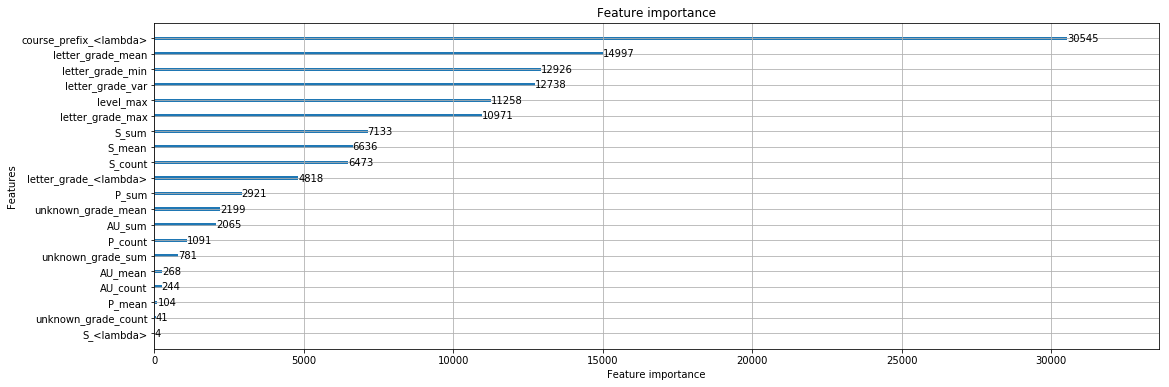

In [178]:
# Plot feature importance
lgb.plot_importance(lgb_clf,figsize=(18,6))

As we expected, the mode of the course_name prefix has the largest feature importance. 

To further improve model predictive accuracy, we could add the second mode of the course_name prfix, the third mode of the course_name prefix..... to prediction features.

In [179]:
# make submission
preds=lgb_clf.predict(df_test[features])

preds= np.argpartition(preds,-3,axis=1)[:,-3:]
preds=pd.DataFrame(preds,columns=['major1','major2','major3'])
preds['student_id']=df_test.student_id
sub=pd.read_csv('eval.psv',delimiter='|').drop(['major1','major2','major3'],axis=1)
sub=pd.merge(left=sub,right=preds,how='left',on='student_id')
#inverse transform the major from label encoder to text
for i in ['major1','major2','major3']:
    sub[i]=le1.inverse_transform(sub[i])
sub.to_csv('sub.psv',sep='|',index=False)